# Lecture 5. Data Compression and Hidden Order
## exercise 1. Lempel-Ziv algorithm (LZ77)

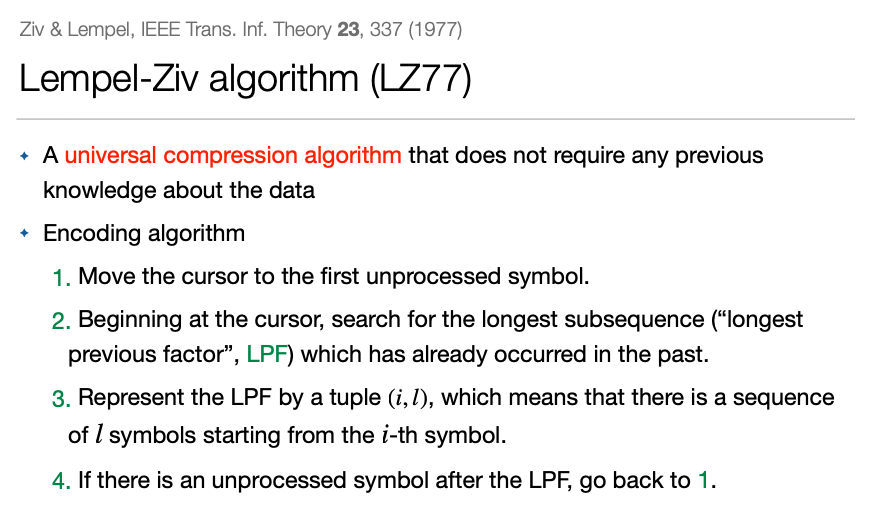

In [ ]:
!pip install bitarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.1/303.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
# example code from https://github.com/manassra/LZ77-Compressor
import math
from bitarray import bitarray

class LZ77Compressor:
    def __init__(self, window_size=16777215):  # 24-bit window size
        self.window_size = window_size
        self.lookahead_buffer_size = 16777215  # Match length at most 24 bits

    def compress(self, input_file_path, output_file_path=None, verbose=False):
        data = None
        i = 0
        output_buffer = bitarray(endian='big')

        try:
            with open(input_file_path, 'rb') as input_file:
                data = input_file.read()
        except IOError:
            print('Could not open input file ...')
            raise

        while i < len(data):
            match = self.findLongestMatch(data, i)
            if match:
                bestMatchDistance, bestMatchLength = match
                output_buffer.append(True)

                # Store match distance (24 bits)
                output_buffer.frombytes(bestMatchDistance.to_bytes(3, byteorder='big'))
                # Store match length (24 bits)
                output_buffer.frombytes(bestMatchLength.to_bytes(3, byteorder='big'))

                if verbose:
                    print(f"<1, {bestMatchDistance}, {bestMatchLength}>", end='')
                i += bestMatchLength
            else:
                output_buffer.append(False)
                output_buffer.frombytes(bytes([data[i]]))
                if verbose:
                    print(f"<0, {data[i]}>", end='')
                i += 1

        output_buffer.fill()
        if output_file_path:
            try:
                with open(output_file_path, 'wb') as output_file:
                    output_file.write(output_buffer.tobytes())
                    print("File was compressed successfully.")
                    return None
            except IOError:
                print('Could not write to output file.')
                raise
        return output_buffer

    def decompress(self, data, output_file_path=None):
#         data = bitarray(endian='big')
        output_buffer = []

#         try:
#             with open(input_file_path, 'rb') as input_file:
#                 data.fromfile(input_file)
#         except IOError:
#             print('Could not open input file ...')
#             raise
        length_seq = []
        while len(data) >= 9:
            flag = data[0]
            data = data[1:]

            if not flag:
                byte = data[:8].tobytes()
                output_buffer.append(byte)
                data = data[8:]
            else:
                if len(data) < 48:
                    break

                distance = int.from_bytes(data[:24].tobytes(), byteorder='big')
                length = int.from_bytes(data[24:48].tobytes(), byteorder='big')
                data = data[48:]

                length_seq.append(length)

                for _ in range(length):
                    output_buffer.append(output_buffer[-distance])

        out_data = b''.join(output_buffer)
        if output_file_path:
            try:
                with open(output_file_path, 'wb') as output_file:
                    output_file.write(out_data)
                    print('File was decompressed successfully.')
                    return None
            except IOError:
                print('Could not write to output file.')
                raise
        return out_data, length_seq

    def findLongestMatch(self, data, current_position):
        end_of_buffer = min(current_position + self.lookahead_buffer_size, len(data) + 1)
        best_match_distance = -1
        best_match_length = -1

        start_index = max(0, current_position - self.window_size)
        for j in range(current_position + 2, end_of_buffer):
            substring = data[current_position:j]
            for i in range(start_index, current_position):
                matched_string = data[i:current_position] * (len(substring) // (current_position - i)) + \
                                 data[i:i + len(substring) % (current_position - i)]
                if matched_string == substring and len(substring) > best_match_length:
                    best_match_distance = current_position - i
                    best_match_length = len(substring)

        return (best_match_distance, best_match_length) if best_match_distance > 0 else None


In [ ]:
# generating data
import os
input_path = os.getcwd()+'/data/input/'

os.makedirs(input_path,exist_ok=True)

In [ ]:
# Pi - pseudorandom
# https://umair-iftikhar.medium.com/calculating-pi-digits-python-a71119a76983
from mpmath import mp
import psutil
import os
import time

def calculate_pi_to_file(file_path, digits, chunk_size=1000):
    """
    Incrementally calculate pi to a specified number of digits and write to a file.

    :param file_path: Path to the file where the result will be stored.
    :param digits: Total number of digits to calculate.
    :param chunk_size: Number of digits to calculate per step.
    """
    # Set precision for mpmath
    mp.dps = chunk_size  # Start with a manageable precision

    # Record the start time of the calculation
    start_time = time.time()

    # Open the file in write mode to clear its contents before starting
    with open(file_path, 'w') as file:
        # Write "3." at the beginning
        file.write("3.")
        print('Added "3." to the beginning of the file.')

    # Open the file again in append mode to start adding digits
    with open(file_path, 'a+') as file:
        total_written = 0

        # Subtract 2 digits for the "3." already written
        while total_written < digits:
            # Set precision for the next chunk
            remaining_digits = min(chunk_size, digits - total_written)
            mp.dps = total_written + remaining_digits

            # Calculate pi to the required precision
            pi_value = str(mp.pi)[total_written + 2:total_written + 2 + remaining_digits]  # Exclude "3."

            # Append digits to the file
            file.write(pi_value)
            total_written += remaining_digits

    # Calculate the total time taken
    end_time = time.time()
    total_time = end_time - start_time
    minutes = total_time // 60
    seconds = total_time % 60

    # Print the final message with time taken
    print(f"Calculation complete. {digits} digits written to {file_path} in {int(minutes)} minutes {int(seconds)} seconds.")

# Example Usage
total_digits = 100000  # Adjust to your target precision
calculate_pi_to_file(input_path+'pi', total_digits)



Added "3." to the beginning of the file.
Calculation complete. 100000 digits written to /content/data/input/pi in 0 minutes 17 seconds.


In [ ]:
# pseudorandom
import numpy as np
def random_to_file(file_path, digits):
    out = ''
    while(len(out)<digits):
      tmp = np.random.randint(10,size=10)
      for w in tmp:
        out+=(str(w))
    with open(file_path, 'w') as file:
      file.write(out[:digits])


# Example Usage
random_to_file(input_path+'random', total_digits)

In [ ]:
# Fibonacci - quasiperiodic
def calculate_Fib_to_file(file_path, digits):
    tmp = ['0','01','010']
    out = ''
    while(len(out)<digits):

        tmp[0] = tmp[1]
        tmp[1] = tmp[2]
        tmp[2] = tmp[1]+tmp[0]
        out = tmp[2]
    with open(file_path, 'w') as file:
        file.write(out[:digits])

# Example Usage
calculate_Fib_to_file(input_path+'Fibonacci', total_digits)

In [ ]:
# periodic
def periodic_to_file(file_path, digits):
    out = ''
    while(len(out)<digits):
      tmp = '012342345487'   # units of periodic numbers
      for w in tmp:
        out+=(str(w))
    with open(file_path, 'w') as file:
      file.write(out[:digits])


# Example Usage
periodic_to_file(input_path+'periodic', total_digits)

In [ ]:
# compressing data
total_digits = 100000  # Adjust to your target precision
import numpy as np

compressor = LZ77Compressor()

compressed_path = os.getcwd()+'/data/compressed/'



In [ ]:
# compress the input file and write it as binary into the output file
file_list = os.listdir(input_path)
for file in file_list:
  try:
    compressor.compress(input_path+file, compressed_path+file)
  except:
    pass


['random_half_new', 'periodic_half_new', 'pi_half_new', 'periodic_full_new', 'Fibonacc_new_full_new']
random_half_new
periodic_half_new
pi_half_new
periodic_full_new
Fibonacc_new_full_new


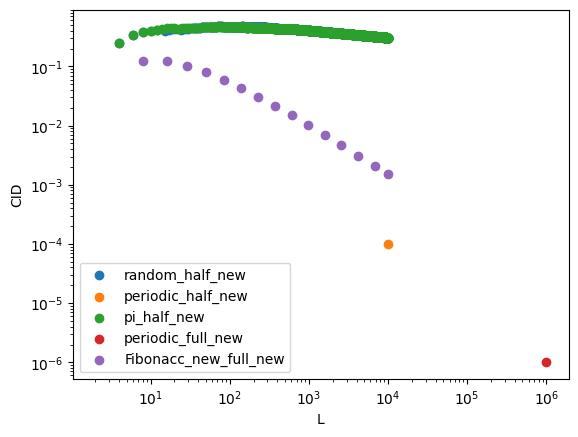

In [ ]:
# computable information density (CID)
import matplotlib.pyplot as plt
compressor = LZ77Compressor()

file_list = os.listdir(compressed_path)
file_list.remove('.ipynb_checkpoints')

print(file_list)
for file in file_list:
    CID = []
    print(file)
    # try:
    with open(compressed_path+file, 'rb') as compressed_file:
        data = bitarray(endian='big')
        data.fromfile(compressed_file)

        code,length_seq = compressor.decompress(data)

        length_axis = np.cumsum(np.array(length_seq))
        plt.scatter(length_axis,np.arange(len(length_axis))/length_axis,label=file)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('CID')
plt.xlabel('L')
plt.legend()
plt.show()
